# VAE code for FIRST Radio Sources

The VAE code generates image of FIRST. It makes use of 7 layers as encoder and 7 layers as decoder. It makes use of Pyro as PPL. Pyro handles the optimization of the neural network. (To include introduction to VAE as well as PPL to include a section of notes on the  Pyro Programming). 

### Introduction of Variational AutoEncoders

### Optimization of the Variational Autoencoder

### Derivation of the ELBO derivation for Variational Autoencoder

In [1]:
import os
import numpy as np
import torch
import torchvision.datasets as dset
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam,Adagrad
import pyro.poutine as poutine
from torchvision.utils import save_image
from FRDEEP import FRDEEPF
from MiraBest import MiraBest
import matplotlib.pylab as plt

from PIL import Image # Module for image rotation (making use of PIL)

In [2]:
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ

## Image Downloader - Takes image from the FRDEEP 
Downloads the database of radio images build by .......... (to look for formal citation)

 It should here be note that we normalise the the pixel intensities between [0.0,1.0] this is a similar technique as that used in the Pyro VAE tutorial. The image are also rotated at steps of 10 degrees. So each image is augmented to 36 further images. This will leave 19800 images that will be used for training the VAE. Those images are then shuffled. No augmentation is performed to the test image as this is not required for the testing phase. 

In [3]:
def dataloader_first():
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5],[0.5])])
    
    trainset = FRDEEPF(root='./FIRST_data', train=True, download=True, transform=transform)  
    trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, num_workers=2, batch_size=len(trainset))
    
    testset = FRDEEPF(root='./FIRST_data', train=False, download=True, transform=transform) 
    testloader = torch.utils.data.DataLoader(testset, shuffle=True, num_workers=2, batch_size=len(testset))
    
    classes = ('FRI', 'FRII')
    
    array_train= next(iter(trainloader))[0].numpy() # Training Datasets is loaded in numpy array
    
    array_label= next(iter(trainloader))[1].numpy() # Training Datasets labels is loaded in seperate numpy array
    
    augmented_data=np.zeros((19800,1,100,100))
    
    count=0
    
    for j in range(0,550):
        image_object=Image.fromarray(array_train[j,0,:,:])
        for i in range(0,36):
            rotated=image_object.rotate(i*10)
            imgarr = np.array(rotated)
            temp_img_array=imgarr[25:125,25:125]
            augmented_data[count,0,:,:]=temp_img_array
            count+=1
           
    augmented_data=(augmented_data-np.min(augmented_data))/(np.max(augmented_data)-np.min(augmented_data))
    
    X=augmented_data
    
    X_random_mix=np.take(X,np.random.permutation(X.shape[0]),axis=0,out=X);
    
    # Have to add the test data to the code. The test data has to be mixed with the training data. 
    
    tensor_x = torch.stack([torch.Tensor(i) for i in X_random_mix])
    
    first_augmented_dataset = torch.utils.data.TensorDataset(tensor_x) # create your datset
    
    first_dataloader = torch.utils.data.DataLoader(first_augmented_dataset,batch_size=100, shuffle=True) # create your dataloader
    
    
    # Cropping of the Testing Images to 100 by 100 pixels

    array_test= next(iter(testloader))[0].numpy()
    test_data_reduced=np.zeros((50,1,100,100))
    for k in range (0,50):
        test_data_reduced[k][0][:][:] = array_test[k][0][25:125,25:125]
    
    test_data_reduced=(test_data_reduced-np.min(test_data_reduced))/(np.max(test_data_reduced)-np.min(test_data_reduced))
    
    
    
    tensor_test = torch.stack([torch.Tensor(i) for i in test_data_reduced])
    
    first_augmented_dataset_test = torch.utils.data.TensorDataset(tensor_test) # create your datset
    
    first_dataloader_test = torch.utils.data.DataLoader(first_augmented_dataset_test,batch_size=50, shuffle=True) # create your dataloader

    
    return first_dataloader, first_dataloader_test

In [4]:
def dataloader_first_2():
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5],[0.5])])
    
    trainset = MiraBest(root='./batches', train=True, download=True, transform=transform)  
    trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, num_workers=2, batch_size=len(trainset))
    
    testset = MiraBest(root='./batches', train=False, download=True, transform=transform) 
    testloader = torch.utils.data.DataLoader(testset, shuffle=True, num_workers=2, batch_size=len(testset))
    
    classes = ('FRI', 'FRII')
    
    array_train= next(iter(trainloader))[0].numpy() # Training Datasets is loaded in numpy array
    
    array_label= next(iter(trainloader))[1].numpy() # Training Datasets labels is loaded in seperate numpy array
    
    augmented_data=np.zeros((25488,1,100,100))
    
    count=0
    
    for j in range(0,704):
        image_object=Image.fromarray(array_train[j,0,:,:])
        for i in range(0,36):
            rotated=image_object.rotate(i*10)
            imgarr = np.array(rotated)
            temp_img_array=imgarr[25:125,25:125]
            augmented_data[count,0,:,:]=temp_img_array
            count+=1
           
    augmented_data=(augmented_data-np.min(augmented_data))/(np.max(augmented_data)-np.min(augmented_data))
    
    X=augmented_data
    
    X_random_mix=np.take(X,np.random.permutation(X.shape[0]),axis=0,out=X);
    
    # Have to add the test data to the code. The test data has to be mixed with the training data. 
    
    tensor_x = torch.stack([torch.Tensor(i) for i in X_random_mix])
    
    first_augmented_dataset = torch.utils.data.TensorDataset(tensor_x) # create your datset
    
    first_dataloader = torch.utils.data.DataLoader(first_augmented_dataset,batch_size=100, shuffle=True) # create your dataloader
    
    
    # Cropping of the Testing Images to 100 by 100 pixels

    array_test= next(iter(testloader))[0].numpy()
    test_data_reduced=np.zeros((88,1,100,100))
    for k in range (0,88):
        test_data_reduced[k][0][:][:] = array_test[k][0][25:125,25:125]
    
    test_data_reduced=(test_data_reduced-np.min(test_data_reduced))/(np.max(test_data_reduced)-np.min(test_data_reduced))
    
    
    
    tensor_test = torch.stack([torch.Tensor(i) for i in test_data_reduced])
    
    first_augmented_dataset_test = torch.utils.data.TensorDataset(tensor_test) # create your datset
    
    first_dataloader_test = torch.utils.data.DataLoader(first_augmented_dataset_test,batch_size=50, shuffle=True) # create your dataloader

    
    return first_dataloader, first_dataloader_test

 ## Encoder
 
 We make use of 7 layers for the Encoder and 7 layers for the Decoder. The images are fo dimension 100 x 100. So the input of the Neural Network is 10000. The neural network then follows the following structure:
 1. 10000 > 4096 
 2. 4096 > 2048
 3. 2048 > 1024
 4. 1024 > 512
 5. 512 > 256
 6. 256 > 2
 
 The decoder is an inverted encoder, where the Neural Network has the structure:
 1. 2 > 256
 2. 256 > 512
 3. 512 > 1024
 4. 1024 > 2048
 5. 2048 > 4096
 6. 4096 > 10000
 
We make use of the leaky relu as Activation Function, this function is used so as eliminate the number of dead neurons in the neural network. As compared to the Relu that simply set every neuron outputs to 2 if the input value of less that 0, a slight negative gradient is asssigned to the ReLU in the Leaky Relu. This will ensure that there are no zero values output by the neuron.
 
It should also be noted that we make use of softplus activation function right after the input layer. This also reduced the risk of producing dead neurons (this should be confirmed). To include the graphs of the Leaky ReLU and that of the Softplus (Try to understand what the Softplus function does)


In [4]:
class Encoder(nn.Module):
    #def __init__(self, z_dim, hidden_dim):
    def __init__(self, x_dim, h_dim1, h_dim2, h_dim3, h_dim4, h_dim5, z_dim):
        super(Encoder, self).__init__()
        # setup the three linear transformations used
        #have to here define the fully connected layers - 784 to 400
        #400 to 2
        
        # setup the non-linearities
        self.fc1 = nn.Linear(x_dim, h_dim1) #x_dim=10000 to h_dim1=4096 
        self.fc2 = nn.Linear(h_dim1, h_dim2) #h_dim1=4096 to h_dim2=2048
        self.fc3 = nn.Linear(h_dim2, h_dim3) #h_dim2=2048 to h_dim3=1024
        self.fc4 = nn.Linear(h_dim3, h_dim4) #h_dim3=1024 to h_dim4=512
        self.fc5 = nn.Linear(h_dim4, h_dim5) #h_dim4=512 to h_dim5=256
        self.fc61 = nn.Linear(h_dim5, z_dim) #h_dim5=256 to z_dim=2
        self.fc62 = nn.Linear(h_dim5, z_dim) #h_dim5=256 to z_dim=2
        
        self.softplus = nn.Softplus()

    def forward(self, x):
        
        x = x.reshape(-1,10000)
        
        slope_param=0.0001
        
        # then compute the hidden units
        # We use fully connected layers
        hidden = self.softplus(self.fc1(x))
        
        
       # hidden = F.leaky_relu(self.fc1(x),slope_param)
        hidden = F.leaky_relu(self.fc2(hidden),slope_param)
        hidden = F.leaky_relu(self.fc3(hidden),slope_param)
        hidden = F.leaky_relu(self.fc4(hidden),slope_param)
        hidden = F.leaky_relu(self.fc5(hidden),slope_param)
        
        z_loc = self.fc61(hidden)
        z_scale = torch.exp(self.fc62(hidden)) # mu, log_var

        return z_loc, z_scale

# Decoder
We make use of 7 layers for the Encoder and 7 layers for the Decoder. The images are fo dimension 100 x 100. So the input of the Neural Network is 10000. The neural network then follows the following structure:
 1. 10000 > 4096 
 2. 4096 > 2048
 3. 2048 > 1024
 4. 1024 > 512
 5. 512 > 256
 6. 256 > 2
 
 The decoder is an inverted encoder, where the Neural Network has the structure:
 1. 2 > 256
 2. 256 > 512
 3. 512 > 1024
 4. 1024 > 2048
 5. 2048 > 4096
 6. 4096 > 10000


In [5]:
class Decoder(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, h_dim3, h_dim4, h_dim5, z_dim):
        super(Decoder, self).__init__()
        
        self.fc7 = nn.Linear(z_dim, h_dim5) #z_dim=2 to h_dim5=256
        self.fc8 = nn.Linear(h_dim5, h_dim4) #h_dim5=256 to h_dim4=512
        self.fc9 = nn.Linear(h_dim4, h_dim3) #h_dim4=512 to h_dim3=1024
        self.fc10 = nn.Linear(h_dim3, h_dim2) #h_dim3=1024 to h_dim2=2048
        self.fc11 = nn.Linear(h_dim2, h_dim1) #h_dim2=2048 to h_dim1=4096
        self.fc12 = nn.Linear(h_dim1, x_dim)  #h_dim1=4096 to x_dim=10000
        
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        slope_param=0.0001
        hidden = F.leaky_relu(self.fc7(z),slope_param)
        hidden = F.leaky_relu(self.fc8(hidden),slope_param)
        hidden = F.leaky_relu(self.fc9(hidden),slope_param)
        hidden = F.leaky_relu(self.fc10(hidden),slope_param)
        hidden = F.leaky_relu(self.fc11(hidden),slope_param)
        
        loc_img = self.sigmoid(self.fc12(hidden))
        
        return  loc_img# <-------- To check this


In [6]:
def simple_elbo_kl_annealing(model, guide, *args, **kwargs):
    # get the annealing factor and latents to anneal from the keyword
    # arguments passed to the model and guide
    annealing_factor = kwargs.pop('annealing_factor', 1.0)
    latents_to_anneal = kwargs.pop('latents_to_anneal', [])
    # run the guide and replay the model against the guide
    guide_trace = poutine.trace(guide).get_trace(*args, **kwargs)
    model_trace = poutine.trace(
        poutine.replay(model, trace=guide_trace)).get_trace(*args, **kwargs)

    elbo = 0.0
    # loop through all the sample sites in the model and guide trace and
    # construct the loss; note that we scale all the log probabilities of
    # samples sites in `latents_to_anneal` by the factor `annealing_factor`
    for site in model_trace.values():
        if site["type"] == "sample":
            factor = annealing_factor if site["name"] in latents_to_anneal else 1.0
            elbo = elbo + factor * site["fn"].log_prob(site["value"]).sum()
    for site in guide_trace.values():
        if site["type"] == "sample":
            factor = annealing_factor if site["name"] in latents_to_anneal else 1.0
            elbo = elbo - factor * site["fn"].log_prob(site["value"]).sum()
    return -elbo


In [7]:
def load_checkpoint():
    log("loading model from ...")
    dmm.load_state_dict(torch.load('/raid/scratch/davidb/VAE_FIRST/models/file_epoch_frdeepadagrad_'+str(epoch)))
    log("loading optimizer states from ...")
    optimizer.load('/raid/scratch/davidb/VAE_FIRST/models/file_epoch_frdeepadagrad_'+str(epoch)+'_opt')
    log("done loading model and optimizer states.")

In [8]:
def save_checkpoint(epoch):
    print("saving model to ...")
    torch.save(vae.state_dict(), '/raid/scratch/davidb/VAE_FIRST/models/file_epoch_frdeepadagrad_'+str(epoch))
    print("saving optimizer states...")
    optimizer.save('/raid/scratch/davidb/VAE_FIRST/models/file_epoch_frdeepadagrad_'+str(epoch)+'_opt')
    print("done saving model and optimizer checkpoints to disk.")

 Once the encoder and the decoder have been written we can write the stochastic functions that will represent the model and the guide. First the model is defined:

 1. The first thing which we do inside of the model is register the decoder module with pyro. This is done by using the pyro.module, this should let the decoder network know all the parameters inside of the decoder network.
 2. Next the hyperparameters are setup for the prior, in our case it is a gaussian distribution. These are denoted as z_loc and z_scale. 
 3. We sample from the latent space z from the prior, making sure to give the random variable Pyro name 'latent'. 
 4. z is passed in the decoder network, which returns loc_img.
 5. We then score the observed images in the minibatch x against the Bernoulli likelihood parameterized by loc_img. The image x is here flatenned.

 1. Just like for the model we first register the module.
 2. The miniBatch of images passes through the encoder.

In [9]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # @David We have changed the latent space to 2-dimensional
    # and we use 400 hidden units
    def __init__(self, x_dim=10000,h_dim1=4096, h_dim2=2048, h_dim3=1024, h_dim4=512, h_dim5=256, z_dim=10, use_cuda=True): # z_dim has been changed to 2
        super(VAE, self).__init__()
        # create the encoder and decoder networks
        #For the first images add addition hidden layers
        self.encoder = Encoder(x_dim, h_dim1, h_dim2, h_dim3, h_dim4, h_dim5, z_dim) #To check the layering structure
        self.decoder = Decoder(x_dim, h_dim1, h_dim2, h_dim3, h_dim4, h_dim5, z_dim) #To check the layering structure

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # Do not touch this part for the time being this will be modified when doing the Semi-Supervised VAE     
    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_img = self.decoder.forward(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 10000))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

## Inference
We here do the inference. The VAE is first instantiated.

In [11]:
vae = VAE()

In [12]:
# Note that the mini batch logic is handled by the data loader, we should duplicate the same logic of the data loader with the FIRST Database. The core of the training loop is svi.step(x). This is the data entry point. It should be noted that we have to change the looping structure to that of the mini batch structure that is used for the FIRST database.

# To do evaluate part afterwards

def evaluate(svi, test_loader, use_cuda=True):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x) #Data entry point <---------------------------------Data Entry Point
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [13]:
def z_space_sampler(epoch):
    z = torch.randn(400, 2).cuda()
    count_x=-4.0
    count_y_2=-4.0
    count_y=count_y_2
    x=0
    y=0
    for i in range (0,20):
        for j in range (0,20):
            z[x,0]=count_x
            z[x,1]=count_y
            x=x+1
            count_y=count_y+0.4
        y=y+1
        count_x=count_x+0.4
        count_y=count_y_2
    sample = vae.decoder(z)
    save_image(sample.view(400,1,100,100),'sample_image_z'+str(epoch)+'.png',nrow=20)

In [14]:
def single_image_sampler(z0=0.0,z1=0.0):
    z = torch.rand(1,2).cuda()
    z[0,0]=z0
    z[0,1]=z1
    single_sample_image = vae.decoder(z)
    image_array_single =single_sample_image.reshape(100,100).cpu().detach().numpy()
    temp_array=image_array_single
    plt.figure(figsize = (10,10))
    plt.imshow(image_array_single)
    plt.colorbar()
    plt.show()
    return image_array_single

In [15]:
# Run options
LEARNING_RATE = 0.3e-3
USE_CUDA = True

In [16]:
# Run only for a single iteration for testing
NUM_EPOCHS = 1 if smoke_test else 10000
TEST_FREQUENCY = 5

In [ ]:
# Core Training section
#--------------------------------------------------------Main VAE Section-----------------------------------------------------
train_loader,test_loader = dataloader_first() #Loads data from FIRST data is strored in train_loader, This part should include 
                                  #a testing data part.

# clear param store
pyro.clear_param_store()

# setup the VAE
vae = VAE(use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
# optimizer = Adam(adam_args)   # The Adam optimizer is used as optimizer
optimizer = Adagrad(adam_args)
# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())
#svi = SVI(vae.model, vae.guide, optimizer, loss=simple_elbo)
#svi = SVI(vae.model, vae.guide, optimizer, loss=simple_elbo_kl_annealing)

#svi.step(annealing_factor=0.2, latents_to_anneal=["my_latent"])

train_elbo = []
test_elbo = []
# training loop

for epoch in range(NUM_EPOCHS):
   # total_epoch_loss_train = train(svi, epoch, train_loader)
    # ------------ To include Training Loop just for test -------------------
    epoch_loss = 0.
   
    for x in train_loader: # Note that _ is the labels only and x are the images.
     # if on GPU put mini-batch into CUDA memory
        
        x = x[0].cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)
        
    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    
    total_epoch_loss_train = epoch_loss / normalizer_train
      
    train_elbo.append(-total_epoch_loss_train)
    
    
    # --------------------------Do testing for each epoch here--------------------------------
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x_test in test_loader:
        # if on GPU put mini-batch into CUDA memory

        x_test = x_test[0].cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x_test) #Data entry point <---------------------------------Data Entry Point
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    print("[epoch %03d]  average training loss: %.4f testing loss: %.4f" % (epoch, total_epoch_loss_train,total_epoch_loss_test))
    
    if epoch%500 == 0:
        save_checkpoint(epoch)

Files already downloaded and verified
Files already downloaded and verified
[epoch 000]  average training loss: 470.1684 testing loss: 164.6331
saving model to ...
saving optimizer states...
done saving model and optimizer checkpoints to disk.
[epoch 001]  average training loss: 187.3801 testing loss: 164.1935
[epoch 002]  average training loss: 186.1466 testing loss: 162.1971
[epoch 003]  average training loss: 185.2271 testing loss: 165.4896
[epoch 004]  average training loss: 184.6868 testing loss: 164.4292
[epoch 005]  average training loss: 184.1580 testing loss: 163.1968
[epoch 006]  average training loss: 183.4930 testing loss: 164.3536
[epoch 007]  average training loss: 182.7022 testing loss: 160.8261
[epoch 008]  average training loss: 180.7251 testing loss: 159.6738
[epoch 009]  average training loss: 174.9838 testing loss: 156.9826
[epoch 010]  average training loss: 171.5949 testing loss: 152.9361
[epoch 011]  average training loss: 170.0605 testing loss: 153.9305
[epoch 0

[epoch 118]  average training loss: 162.3725 testing loss: 146.7811
[epoch 119]  average training loss: 162.3713 testing loss: 146.7517
[epoch 120]  average training loss: 162.3609 testing loss: 146.8737
[epoch 121]  average training loss: 162.3711 testing loss: 146.5234
[epoch 122]  average training loss: 162.3604 testing loss: 146.3282
[epoch 123]  average training loss: 162.3426 testing loss: 146.4929
[epoch 124]  average training loss: 162.3491 testing loss: 146.5029
[epoch 125]  average training loss: 162.3489 testing loss: 146.6343
[epoch 126]  average training loss: 162.3280 testing loss: 146.5917
[epoch 127]  average training loss: 162.3339 testing loss: 146.5061
[epoch 128]  average training loss: 162.3312 testing loss: 146.6797
[epoch 129]  average training loss: 162.3152 testing loss: 146.5625
[epoch 130]  average training loss: 162.3247 testing loss: 146.6096
[epoch 131]  average training loss: 162.3247 testing loss: 146.4478
[epoch 132]  average training loss: 162.3062 tes

[epoch 239]  average training loss: 162.0827 testing loss: 146.3482
[epoch 240]  average training loss: 162.0688 testing loss: 146.1939
[epoch 241]  average training loss: 162.0675 testing loss: 146.0741
[epoch 242]  average training loss: 162.0624 testing loss: 146.3179
[epoch 243]  average training loss: 162.0541 testing loss: 146.2802
[epoch 244]  average training loss: 162.0632 testing loss: 146.7677
[epoch 245]  average training loss: 162.0555 testing loss: 146.4350
[epoch 246]  average training loss: 162.0440 testing loss: 146.3047
[epoch 247]  average training loss: 162.0496 testing loss: 146.5041
[epoch 248]  average training loss: 162.0558 testing loss: 146.3138
[epoch 249]  average training loss: 162.0594 testing loss: 146.0723
[epoch 250]  average training loss: 162.0556 testing loss: 146.1732
[epoch 251]  average training loss: 162.0540 testing loss: 146.5033
[epoch 252]  average training loss: 162.0439 testing loss: 146.2235
[epoch 253]  average training loss: 162.0435 tes

[epoch 360]  average training loss: 161.9150 testing loss: 146.0050
[epoch 361]  average training loss: 161.9122 testing loss: 146.1486
[epoch 362]  average training loss: 161.9186 testing loss: 146.0542
[epoch 363]  average training loss: 161.9285 testing loss: 146.0758
[epoch 364]  average training loss: 161.9406 testing loss: 146.3320
[epoch 365]  average training loss: 161.9158 testing loss: 146.0668
[epoch 366]  average training loss: 161.9165 testing loss: 146.1966
[epoch 367]  average training loss: 161.9116 testing loss: 146.0803
[epoch 368]  average training loss: 161.9048 testing loss: 146.0530
[epoch 369]  average training loss: 161.9168 testing loss: 146.0527
[epoch 370]  average training loss: 161.9297 testing loss: 146.1083
[epoch 371]  average training loss: 161.9151 testing loss: 146.0805
[epoch 372]  average training loss: 161.9104 testing loss: 146.6381
[epoch 373]  average training loss: 161.9100 testing loss: 146.0112
[epoch 374]  average training loss: 161.9181 tes

[epoch 481]  average training loss: 161.8266 testing loss: 145.9789
[epoch 482]  average training loss: 161.8042 testing loss: 145.8723
[epoch 483]  average training loss: 161.7964 testing loss: 146.1232
[epoch 484]  average training loss: 161.8025 testing loss: 146.2019
[epoch 485]  average training loss: 161.8172 testing loss: 146.0542
[epoch 486]  average training loss: 161.8116 testing loss: 145.8541
[epoch 487]  average training loss: 161.8069 testing loss: 145.9017
[epoch 488]  average training loss: 161.8186 testing loss: 145.7890
[epoch 489]  average training loss: 161.8216 testing loss: 145.7943
[epoch 490]  average training loss: 161.8086 testing loss: 146.1578
[epoch 491]  average training loss: 161.8001 testing loss: 146.1161
[epoch 492]  average training loss: 161.7975 testing loss: 146.1426
[epoch 493]  average training loss: 161.8022 testing loss: 145.9391
[epoch 494]  average training loss: 161.8060 testing loss: 145.9637
[epoch 495]  average training loss: 161.7990 tes

[epoch 601]  average training loss: 161.6484 testing loss: 145.9692
[epoch 602]  average training loss: 161.6424 testing loss: 146.0076
[epoch 603]  average training loss: 161.6433 testing loss: 146.0322
[epoch 604]  average training loss: 161.6424 testing loss: 146.0781
[epoch 605]  average training loss: 161.6558 testing loss: 145.8171
[epoch 606]  average training loss: 161.6540 testing loss: 145.9774
[epoch 607]  average training loss: 161.6377 testing loss: 145.6976
[epoch 608]  average training loss: 161.6395 testing loss: 146.4103
[epoch 609]  average training loss: 161.6425 testing loss: 146.3121
[epoch 610]  average training loss: 161.6451 testing loss: 145.9858
[epoch 611]  average training loss: 161.6341 testing loss: 145.8695
[epoch 612]  average training loss: 161.6429 testing loss: 146.0778
[epoch 613]  average training loss: 161.6257 testing loss: 145.9425
[epoch 614]  average training loss: 161.6429 testing loss: 146.1034
[epoch 615]  average training loss: 161.6336 tes

In [18]:
# Plot Reduced Dimension of Real Data
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5],[0.5])])
trainset = FRDEEPF(root='./FIRST_data', train=True, download=True, transform=transform)  
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, num_workers=2, batch_size=len(trainset))

Files already downloaded and verified


In [19]:
trainloader

In [20]:
for x in trainloader:
    x = x[0].cuda()

In [21]:
array_train= next(iter(trainloader))[0].numpy()

In [22]:
array_train

array([[[[-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         ...,
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.]]],


       [[[-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         ...,
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.]]],


       [[[-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         ...,
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.]]],


       ...,


       [[[-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1

In [560]:
array_train=(array_train-np.min(array_train))/(np.max(array_train)-np.min(array_train))

In [562]:
array_train_cuda = torch.from_numpy(array_train).float().to("cuda:0")

In [564]:
array_train_cuda

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [621]:
sample = vae.encoder(array_train_cuda[1][0][25:125,25:125])

In [622]:
source_original_test=array_train_cuda[1][0][25:125,25:125].cpu().detach().numpy()

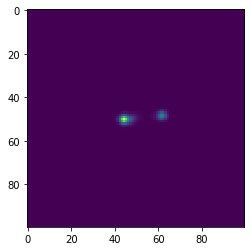

In [623]:
plt.imshow(source_original_test)

In [634]:
reduced_dimension_array = np.zeros((550,2))

In [636]:
reduced_dimension_array[:,1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [649]:
for ii in range (0,550):
    reduced_dimension_array[ii,:]=vae.encoder(array_train_cuda[ii][0][25:125,25:125])[0].cpu().detach().numpy()

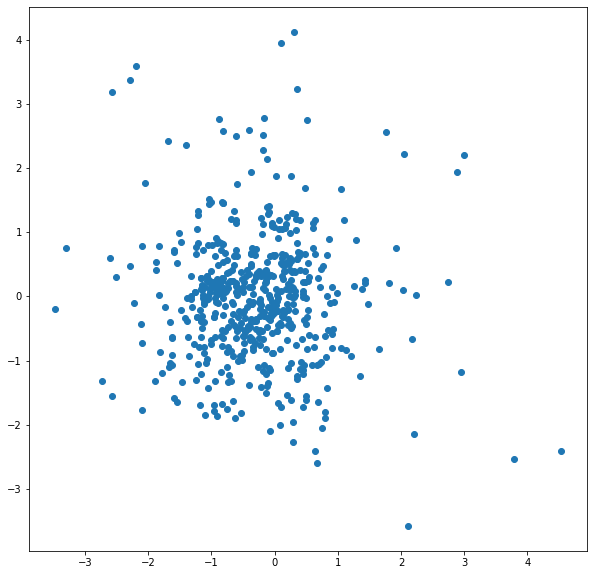

In [652]:
plt.figure(figsize = (10,10))
plt.scatter(reduced_dimension_array[:,0],reduced_dimension_array[:,1])

In [645]:
vae.encoder(array_train_cuda[ii][0][25:125,25:125])[0].cpu().detach().numpy()

array([[0.02483809, 1.8742533 ]], dtype=float32)

In [640]:
sample[ii][0].cpu().detach().numpy()

IndexError: tuple index out of range

In [624]:
array_train_cuda[1][0][25:125,25:125].shape

torch.Size([100, 100])

In [549]:
save_checkpoint(80)

saving model to ...
saving optimizer states...
done saving model and optimizer checkpoints to disk.


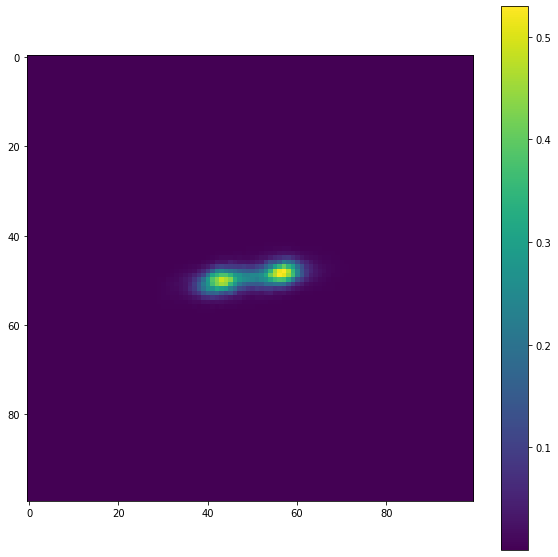

In [626]:
image = single_image_sampler(0.3173, 0.3743)

In [23]:
image.reshape(10000,)

array([0.0018606 , 0.00204189, 0.00225925, ..., 0.00335811, 0.0033211 ,
       0.00319268], dtype=float32)

In [ ]:
hist, bin_edges = np.histogram(image.reshape(10000,),range =(0.0,0.00020),bins = 20)
plt.bar(bin_edges[:-1], hist, width = 0.000005, color='#0504aa',alpha=0.7)

In [ ]:
bin_edges[:-1].mean()

In [ ]:
RMS

In [ ]:
new_image_only_noise = image

In [ ]:
new_image_only_noise[new_image_only_noise > 0.0002] = 0.0 

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(new_image_only_noise)
plt.colorbar()
plt.show()

In [43]:
bin_edges[:-1].shape

(10,)

In [150]:
import numpy as np

In [151]:
levels=np.logspace(0.9, 2.7, 10)

In [152]:
levels = np.arange(0.0, 1.0, 0.1)

In [153]:
levels

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

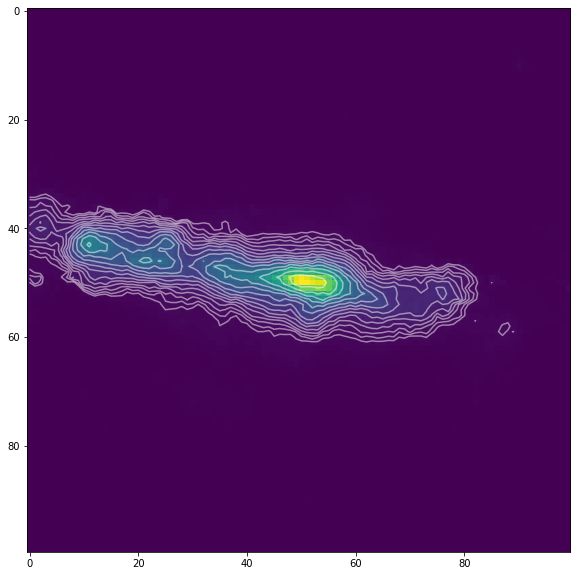

In [241]:
 for i in range ()
    image = single_image_sampler(0.5,-4.0)
    plt.figure(figsize = (10,10))
    plt.imshow(image)
    plt.contour(image, levels=np.logspace(-2, 10,100.0), colors='white', alpha=0.5)
    plt.show()

In [246]:
x_initial = -4.0
y_initial = -4.0

for i in range (0,17):
    for j in range (0,17):
        image = single_image_sampler(x_initial,y_initial)
        plt.figure(figsize = (10,10))
        plt.imshow(image)
        plt.contour(image, levels=np.logspace(-2, 10,100.0), colors='white', alpha=0.5)
        plt.savefig(((str(x_initial).replace('.',''))+'_'+((str(y_initial).replace('.',''))+'.png')))
        x_initial = x_initial + 0.5
    x_initial = -4.0
    y_initial = y_initial + 0.5

/usr/local/anaconda-python-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


In [263]:
import numpy as np
phi = 2.*np.pi

for i in range (0,1000):
        x = ((4*phi)/(2*np.pi)*np.cos(phi))
        y = ((4*phi)/(2*np.pi)*np.sin(phi))
        print(x)
        print(y)
        image = single_image_sampler(x,y)
        plt.figure(figsize = (10,10))
        plt.imshow(image)
        plt.contour(image, levels=np.logspace(-2, 10,100.0), colors='white', alpha=0.5)
        plt.savefig('Radio_Simulation_Spiral/'+str(i)+'.png')
        phi = phi - (2*np.pi/1000.)

4.0
-9.797174393178826e-16


/usr/local/anaconda-python-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


3.9959211223811244
-0.025107443286372988
3.9916848084616343
-0.050163631214341475
3.9872915412946677
-0.07516757758504412
3.982741810104668
-0.10011830024625129
3.978036110255613
-0.12501482113094384
3.9731749432189845
-0.14985616629565143
3.9681588165415134
-0.1746413659585496
3.9629882438126804
-0.19936945453731428
3.9576637446319802
-0.22403947068673238
3.952185844575959
-0.24865045733606667
3.9465550751650107
-0.27320146172617354
3.9407719738299507
-0.2976915354463728
3.934837083878355
-0.32211973447106723
3.9287509544606776
-0.3464851191961108
3.9225141405361414
-0.3707867544749247
3.9161272028384038
-0.3950237096543587
3.909590707841007
-0.4191950586102974
3.9029052277226004
-0.44329987978301005
3.896071340331957
-0.4673372562122414
3.8890896291527617
-0.4913062755720438
3.881960683268197
-0.515206030205348
3.87468509732531
-0.5390356171582725
3.8672634714991707
-0.5627941382141685
3.8596964114568277
-0.5864806999274012
3.851984528321049
-0.6100944136568647
3.844128438633867
-0.6

0.6849697779854121
-3.0643786324876614
0.6648542967158328
-3.064712835509851
0.6447616906675387
-3.0649153923473764
0.6246928190493366
-3.0649866038579243
0.6046485381911596
-3.0649267764929773
0.584629701507734
-3.0647362222735124
0.5646371594624341
-3.064415258765453
0.544671759531334
-3.063964209054894
0.5247343461674526
-3.063383401723095
0.5048257607651953
-3.0626731708212334
0.4849468416249931
-3.06183385584494
0.46509842391814205
-3.060865801708596
0.4452813396518427
-3.0597693587194135
0.4254964176344421
-3.0585448825512773
0.4057444834408797
-3.0571927342183787
0.3860263593783384
-3.055713280048614
0.3663428644521013
-3.0541068916567706
0.3466948143316184
-3.0523739459174917
0.3270830213167808
-3.0505148249380203
0.30750829430440646
-3.0485299160307333
0.2879714387549385
-3.0464196116854567
0.26847325665935645
-3.044184309541569
0.24901454650630284
-3.041824412359895
0.22959610324942553
-3.0393403279943887
0.21021871827493843
-3.0367324693636095
0.1908831793694004
-3.034001254

-2.043113866555236
-1.073568688203098
-2.0462663780663384
-1.058871998872232
-2.04931500563318
-1.0441781494012812
-2.052259909851238
-1.0294878641430376
-2.055101256311699
-1.0148018655414857
-2.057839215583798
-1.0001208740976575
-2.0604739631969187
-0.9854456083356331
-2.0630056796224703
-0.9707767847686882
-2.0654345502555302
-0.9561151178655933
-2.0677607653962604
-0.9414613200170635
-2.0699845202310967
-0.9268161015023612
-2.072106014813712
-0.9121801704560535
-2.0741254540457543
-0.897554232834925
-2.0760430476573624
-0.8829389923850491
-2.07785901018746
-0.8683351506090171
-2.079573560963825
-0.8537434067333286
-2.081186924082946
-0.8391644576759435
-2.0826993283896513
-0.8245989980139976
-2.08411100745653
-0.8100477199516827
-2.085422199563131
-0.7955113132882936
-2.0866331476749473
-0.7809904653864427
-2.087744099422193
-0.766485861140443
-2.0887553070783595
-0.7519981829448634
-2.089667027538569
-0.7375281106632545
-2.090479522297712
-0.7230763215970484
-2.091193057428381
-0

-0.9940898935543412
1.0856193087511652
-0.9845664263560981
1.088876922380404
-0.9750413739239374
1.0920578369009388
-0.9655153233727246
1.0951621616604088
-0.9559888603764976
1.0981900103517066
-0.9464625691370687
1.1011415009991652
-0.9369370323527482
1.104016755944519
-0.9274128311871805
1.1068159018326453
-0.9178905452383057
1.1095390695970824
-0.9083707525074391
1.1121863944453292
-0.8988540293684752
1.1147580158439263
-0.8893409505372166
1.1172540775033182
-0.879832089040828
1.1196747273624972
-0.8703280161874183
1.122020117573434
-0.8608293015357528
1.12429040448529
-0.8513365128650942
1.1264857486284188
-0.8418502161451776
1.1286063146981524
-0.832370975506318
1.1306522715383747
-0.822899353209653
1.1326237921248874
-0.8134359096175225
1.1345210535485617
-0.8039812031639866
1.1363442369982841
-0.794535790325482
1.1380935277436934
-0.7851002255916205
1.1397691151177107
-0.7756750614361295
1.141371192498864
-0.7662608482879355
1.1428999572934082
-0.7568581345023949
1.1443556109172

0.34643360675463414
0.5238012563091735
0.34749038468861027
0.518291841098289
0.34849169426830295
0.51278995605033
0.34943767266206505
0.5072960801392128
0.3503284608638737
0.5018106909072781
0.35116420368072376
0.4963342644361488
0.35194504971980606
0.4908672753176895
0.35267115137547106
0.485410196625069
0.3533426648159795
0.47996349988392906
0.3539597499700403
0.47452765504365896
0.3545225705131367
0.46910313044877955
0.35503129385364074
0.4636903928104354
0.3554860911187185
0.45828990717799967
0.35588713714002573
0.45290213691079145
0.3562346104391945
0.4475275436499071
0.35652869321311303
0.4421665872901677
0.3567695713189982
0.4368197259521839
0.3569574342592633
0.4314874159545397
0.357092475166179
0.426170111786096
0.35717489078633224
0.4208682660784163
0.3572048814648815
0.4155823295783163
0.3571826511296092
0.4103127511205369
0.3571084072747739
0.40505997760054424
0.35698236094476166
0.39982445394745725
0.35680472671753877
0.3946066230971046
0.35657572268790555
0.38940692596521

In [254]:
np.pi

3.141592653589793

In [242]:
x_initial = 0.0

In [243]:
str(x_initial).replace('.','')

'00'

0.3513261

In [ ]:
for i in range (0,1000):
    z1 = np.random.uniform(-4.0, 4.0)
    z2 = np.random.uniform(-4.0, 4.0)
    string_z1 = str(z1).replace('.','_').replace('-','MINUS')
    string_z2 = str(z2).replace('.','_').replace('-','MINUS')
    image = single_image_sampler(z1,z2)
    img_max = image.max()   
    plt.figure(figsize = (10,10))
    plt.imshow(image)
    plt.contour(image, levels=[0,0.02*img_max,0.04*img_max,0.06*img_max,0.10*img_max,0.20*img_max,0.40*img_max,0.60*img_max,0.80*img_max], colors='white', alpha=0.5)
    plt.savefig('plot_images/'+string_z1+'_'+string_z2+'_'+'.png')

In [497]:
image.std()

0.052430324

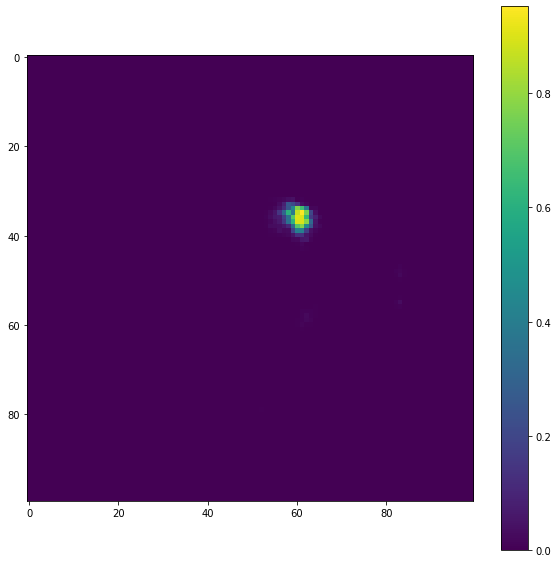

In [92]:
image = single_image_sampler(4.0,-50.0)

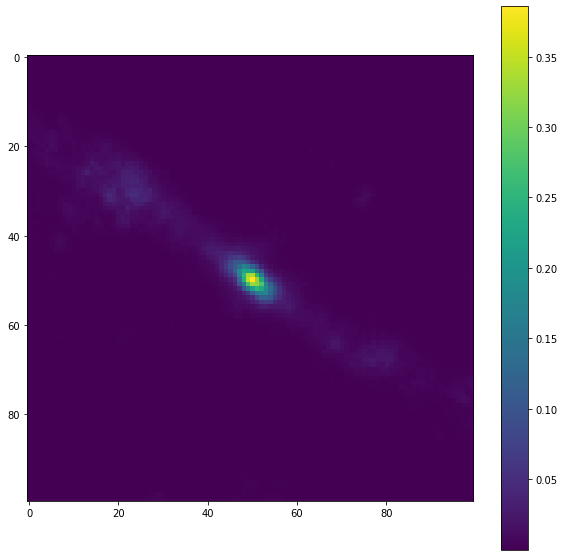

In [65]:
image_tuple=np.where(image < 0.0)
plt.figure(figsize = (10,10))
plt.imshow(image)
plt.plot(image_tuple[1],image_tuple[0],'r+')
plt.colorbar()
plt.show()

In [1]:
from astroquery.skyview import SkyView

ModuleNotFoundError: No module named 'astroquery'

In [87]:
train_loader,test_loader = dataloader_first()

Files already downloaded and verified
Files already downloaded and verified


In [272]:
test_loader[0]

TypeError: 'DataLoader' object does not support indexing

In [90]:
for x in test_loader: # Note that _ is the labels only and x are the images.       
        x = x[0].cuda()
        print(x)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [25]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5],[0.5])])
    
trainset = MiraBest(root='./batches', train=True, download=True, transform=transform)  
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, num_workers=2, batch_size=len(trainset))

array_train= next(iter(trainloader))[0].numpy()

Files already downloaded and verified


In [26]:
augmented_data=array_train

In [27]:
augmented_data=(augmented_data-np.min(augmented_data))/(np.max(augmented_data)-np.min(augmented_data))

In [35]:
augmented_data

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       ...,


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]

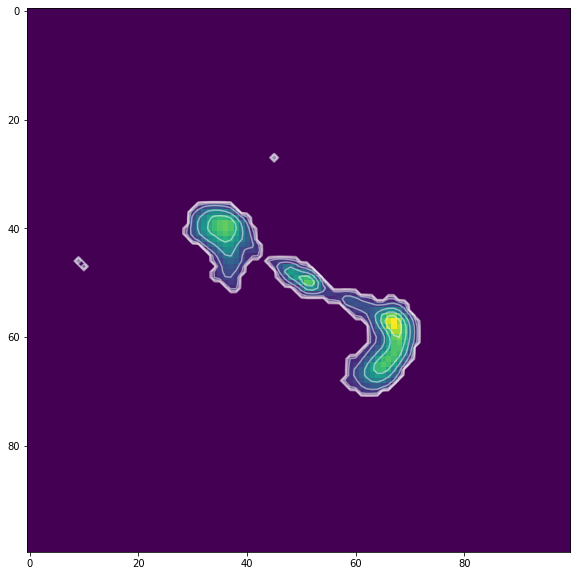

In [32]:
j = 261
image_temp = augmented_data[j][0]
image = image_temp[25:125,25:125]
img_max = image.max()   
plt.figure(figsize = (10,10))
plt.imshow(image)
plt.contour(image, levels=[0.02*img_max,0.04*img_max,0.06*img_max,0.10*img_max,0.20*img_max,0.40*img_max,0.60*img_max,0.80*img_max], colors='white', alpha=0.5)
plt.show()

In [288]:
img_max = image.max()   

In [289]:
img_max

1.0